In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import zscore
from glob import glob
from itertools import product

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shapely
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
# from src.grid_generation import *

In [2]:
# Month of data to load (unable to read more than one more due to pc memory bandwidth)
YEAR = '2021'
MONTH = '12'
MINUTES_WINDOW_SIZE = '15Min'

In [3]:
#Load data and filter essential columns
data = pd.read_parquet(f"../../data/Tlc-Trip-Record-Data/{YEAR}/yellow_tripdata_{YEAR}-{MONTH}.parquet")
data = data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'total_amount']]
data

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,total_amount
0,2021-12-01 00:19:51,2021-12-01 00:37:01,138,141,45.70
1,2021-12-01 00:29:07,2021-12-01 00:45:13,238,42,16.80
2,2021-12-01 00:12:40,2021-12-01 00:27:17,239,74,19.30
3,2021-12-01 00:10:18,2021-12-01 00:19:20,148,87,12.35
4,2021-12-01 00:25:12,2021-12-01 00:39:07,231,246,18.80
...,...,...,...,...,...
3214364,2021-12-31 23:18:02,2021-12-31 23:32:19,145,107,26.52
3214365,2021-12-31 23:46:00,2022-01-01 00:07:00,236,158,29.20
3214366,2021-12-31 23:46:00,2022-01-01 00:04:00,48,13,29.50
3214367,2021-12-31 23:53:00,2022-01-01 00:02:00,75,75,16.00


In [4]:
# Join gdf geometry to data according to PULocationID
manhattan_gdf = gpd.read_file('../../data/new_data/taxi_zones/taxi_zones.shp')
manhattan_gdf = manhattan_gdf[manhattan_gdf.borough == 'Manhattan']

manhattan_gdf["PULocationID"] = manhattan_gdf.LocationID
data = manhattan_gdf.merge(data, on='PULocationID', how='inner')

In [5]:
# Change pickup and dropoff datetime to datetime format
data.tpep_pickup_datetime = pd.to_datetime(data["tpep_pickup_datetime"])
data.tpep_dropoff_datetime = pd.to_datetime(data["tpep_dropoff_datetime"])

In [6]:
# Extract year & month
data["y_m"] = pd.to_datetime(data["tpep_pickup_datetime"]).dt.strftime('%Y-%m')

In [7]:
# Filter date
mask = (data['y_m'] >= data['y_m'].head(1).values[0]) & (data['y_m'] <= data['y_m'].tail(1).values[0])
data = data.loc[mask]

In [8]:
# Get date only
data["y_m_d"] = pd.to_datetime(data["tpep_pickup_datetime"]).dt.strftime('%Y-%m-%d')

In [9]:
# Extract hour of a day for PU (12AM = 0, 11PM = 23)
data["hour"] = data.tpep_pickup_datetime.dt.hour

In [10]:
# Label rows according to 15 mins window
data["mins"] = data.tpep_pickup_datetime.dt.floor(MINUTES_WINDOW_SIZE).dt.minute

In [11]:
# Concat PULocationID with DOLocation
data['p2p'] = data[["PULocationID", "DOLocationID"]].astype(str).agg('_'.join, axis=1)

In [12]:
data

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,tpep_pickup_datetime,tpep_dropoff_datetime,DOLocationID,total_amount,y_m,y_m_d,hour,mins,p2p
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-12-01 00:36:45,2021-12-01 00:51:37,236,26.16,2021-12,2021-12-01,0,30,4_236
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-12-01 00:14:23,2021-12-01 00:44:00,257,55.62,2021-12,2021-12-01,0,0,4_257
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-12-01 00:47:27,2021-12-01 01:04:11,163,22.56,2021-12,2021-12-01,0,45,4_163
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-12-01 01:17:23,2021-12-01 01:31:01,112,18.80,2021-12,2021-12-01,1,15,4_112
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-12-01 04:49:57,2021-12-01 05:02:41,237,21.36,2021-12,2021-12-01,4,45,4_237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889256,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-12-31 21:16:19,2021-12-31 21:31:53,231,34.88,2021-12,2021-12-31,21,15,263_231
2889257,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-12-31 22:20:26,2021-12-31 22:25:10,237,11.63,2021-12,2021-12-31,22,15,263_237
2889258,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-12-31 22:11:50,2021-12-31 22:25:11,234,22.43,2021-12,2021-12-31,22,0,263_234
2889259,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-12-31 22:43:00,2021-12-31 22:52:00,42,18.50,2021-12,2021-12-31,22,30,263_42


In [13]:
a = data['PULocationID'].unique()
print(len(a))

66


In [14]:
# Merge the grid ids of data to the grid geoPandas dataframe
pu_count = pd.DataFrame()
pu_count['count'] = data.groupby(['PULocationID', 'y_m_d', 'hour', 'mins']).size()
pu_count['ave_total_amount'] = data.groupby(['PULocationID', 'y_m_d', 'hour', 'mins'])['total_amount'].agg(['mean'])
pu_count['LocationID'] = pu_count.index.get_level_values('PULocationID')
pu_count['y_m_d'] = pu_count.index.get_level_values('y_m_d')
pu_count['hour'] = pu_count.index.get_level_values('hour')
pu_count['mins'] = pu_count.index.get_level_values('mins')
pu_count['time_slot'] = pd.to_datetime(pu_count['y_m_d'] + ' ' + pu_count['hour'].astype(str) + ':' + pu_count['mins'].astype(str))
pu_count = manhattan_gdf.merge(pu_count, on='PULocationID', how='inner')

In [15]:
pu_count

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID_x,borough,geometry,PULocationID,count,ave_total_amount,LocationID_y,y_m_d,hour,mins,time_slot
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,55.620000,4,2021-12-01,0,0,2021-12-01 00:00:00
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,26.160000,4,2021-12-01,0,30,2021-12-01 00:30:00
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,22.560000,4,2021-12-01,0,45,2021-12-01 00:45:00
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,18.800000,4,2021-12-01,1,15,2021-12-01 01:15:00
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,21.360000,4,2021-12-01,4,45,2021-12-01 04:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152682,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,18,16.807222,263,2021-12-31,22,45,2021-12-31 22:45:00
152683,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,18,17.310000,263,2021-12-31,23,0,2021-12-31 23:00:00
152684,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,21,15.519524,263,2021-12-31,23,15,2021-12-31 23:15:00
152685,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,27,13.326667,263,2021-12-31,23,30,2021-12-31 23:30:00


In [16]:
# Pivot table
pu_count_table = pu_count.pivot_table(index="time_slot", columns="PULocationID", values="count")
pu_count_table.reset_index().rename_axis(None, axis=1)
pu_count_table = pu_count_table.fillna(0)
pu_count_table.sort_values(by='time_slot', inplace = True) 

In [17]:
pu_count_table

PULocationID,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
time_slot,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:00:00,1.0,0.0,1.0,1.0,2.0,1.0,5.0,1.0,31.0,5.0,...,14.0,5.0,8.0,0.0,0.0,6.0,18.0,1.0,1.0,7.0
2021-12-01 00:15:00,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,17.0,4.0,...,7.0,6.0,7.0,0.0,1.0,3.0,33.0,0.0,0.0,4.0
2021-12-01 00:30:00,1.0,0.0,0.0,1.0,1.0,2.0,4.0,1.0,16.0,0.0,...,16.0,2.0,2.0,0.0,0.0,4.0,17.0,2.0,1.0,4.0
2021-12-01 00:45:00,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,20.0,1.0,...,4.0,2.0,3.0,0.0,1.0,4.0,24.0,2.0,1.0,6.0
2021-12-01 01:00:00,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,11.0,1.0,...,8.0,1.0,4.0,0.0,0.0,1.0,19.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:45:00,0.0,0.0,3.0,6.0,5.0,0.0,9.0,0.0,29.0,11.0,...,27.0,16.0,26.0,0.0,0.0,8.0,29.0,3.0,3.0,18.0
2021-12-31 23:00:00,5.0,0.0,0.0,4.0,5.0,1.0,7.0,2.0,41.0,10.0,...,27.0,24.0,18.0,0.0,0.0,9.0,38.0,1.0,13.0,18.0
2021-12-31 23:15:00,0.0,0.0,0.0,2.0,2.0,0.0,9.0,0.0,32.0,18.0,...,22.0,14.0,21.0,0.0,1.0,13.0,35.0,5.0,10.0,21.0


In [18]:
pu_count_table.to_csv(f'../../Time_Series_CSVs/{YEAR}/{YEAR}_{MONTH}_Time_Series.csv', index=True, header=True)

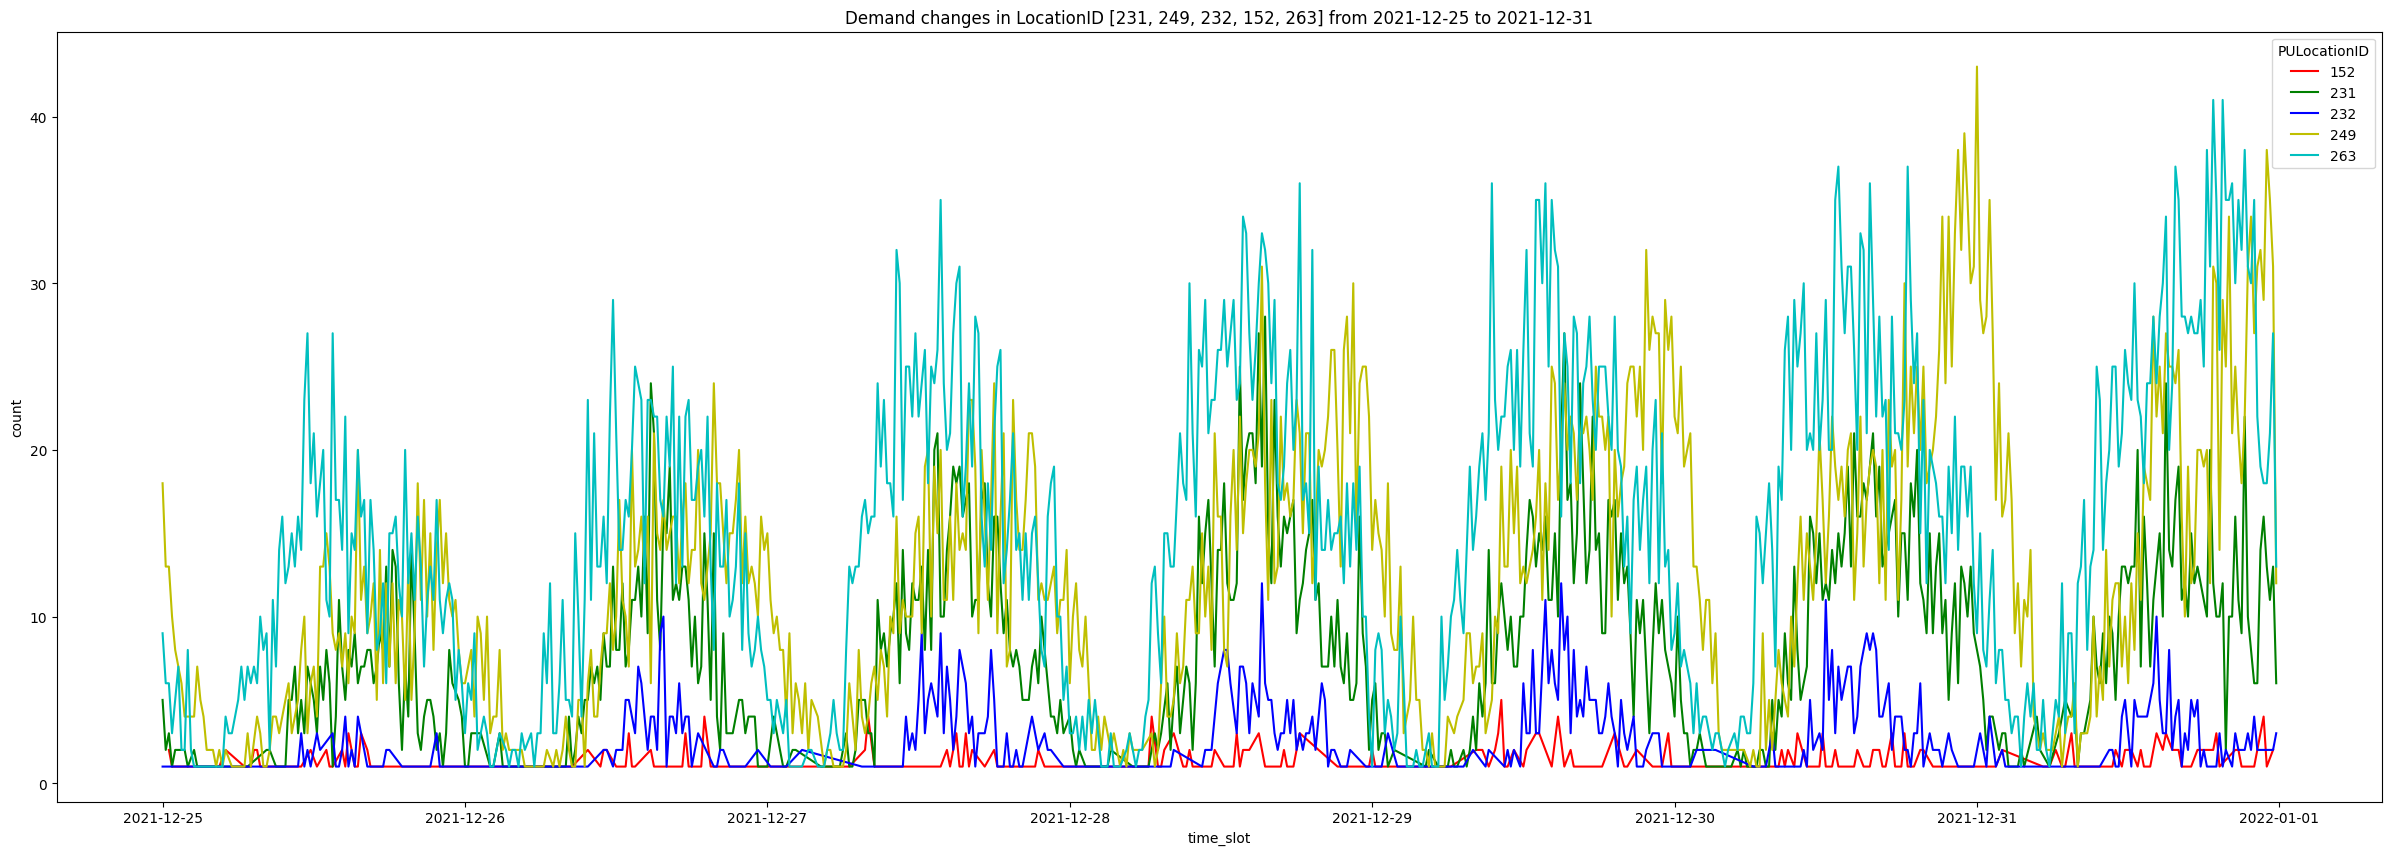

In [19]:
# Plot demand changes of 5 randomly selected regions across 7 days
days_of_data = 7
pu_count.sort_values(by='time_slot', ascending = False, inplace = True)
date_range = [x for x in pd.to_datetime(pu_count.y_m_d).dt.strftime('%Y-%m-%d').unique()[:days_of_data]]

pu_count_gr_7days = pu_count.loc[(pd.to_datetime(pu_count.y_m_d)).isin(date_range)]
rand_loc = list(pu_count_gr_7days.PULocationID.sample(n=5, random_state=1))
pu_count_gr_7days = pu_count_gr_7days.loc[pu_count_gr_7days.PULocationID.isin(rand_loc)]

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title(f"Demand changes in LocationID {rand_loc} from {pu_count_gr_7days.y_m_d.iloc[-1]} to {pu_count_gr_7days.y_m_d.iloc[0]}")
pu_plot_7 = sns.lineplot(ax=ax, data=pu_count_gr_7days,  x="time_slot", y="count", hue="PULocationID", palette=['r', 'g', 'b', 'y', 'c'])

In [20]:
PULocationIDFeatures = pd.DataFrame()

PULocationIDFeatures['ave_total_amount'] = pu_count.groupby(['PULocationID'])['ave_total_amount'].agg(['mean'])

PULocationIDFeatures

,ave_total_amount
PULocationID,
4,22.804738
12,24.011266
13,25.259610
24,17.470481
41,17.207665
...,...
246,18.679415
249,18.287843
261,25.523155


In [21]:
zone_features1 = pd.read_csv('../../zone_features.csv')
PULocationIDFeatures2 = pd.merge(PULocationIDFeatures, zone_features1, on='PULocationID', how="inner")
PULocationIDFeatures2

,PULocationID,ave_total_amount,zone,school,school_school,school_primary_school,school_secondary_school,school_university,food,food_bar,...,adhoc_store,adhoc_storage,adhoc_travel_agency,adhoc_veterinary_care,religious,religious_church,religious_cemetery,religious_hindu_temple,religious_mosque,religious_synagogue
0,4,22.804738,Alphabet City,0,0,0,0,0,1,1,...,1,0,0,0,1,1,0,0,0,0
1,12,24.011266,Battery Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,25.259610,Battery Park City,1,1,0,0,0,1,1,...,1,0,0,0,1,1,0,0,0,0
3,24,17.470481,Bloomingdale,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,41,17.207665,Central Harlem,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,246,18.679415,West Chelsea/Hudson Yards,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,249,18.287843,West Village,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
63,261,25.523155,World Trade Center,1,1,0,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
64,262,18.695503,Yorkville East,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0


<Axes: ylabel='Density'>

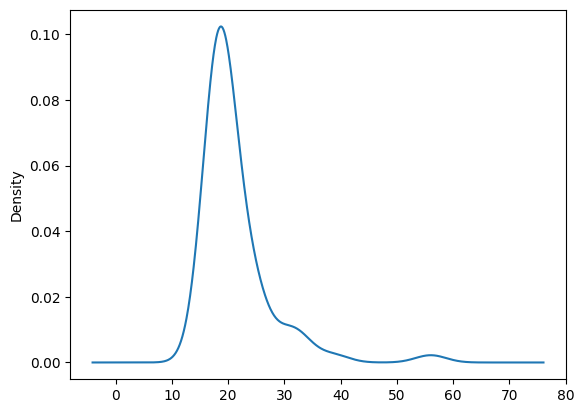

In [22]:
PULocationIDFeatures2['ave_total_amount'].plot(kind='kde')

In [23]:
a = pd.read_csv(f'../../Time_Series_CSVs/{YEAR}/{YEAR}_{MONTH}_Time_Series.csv')
a

,time_slot,4,12,13,24,41,42,43,45,48,...,237,238,239,243,244,246,249,261,262,263
0,2021-12-01 00:00:00,1.0,0.0,1.0,1.0,2.0,1.0,5.0,1.0,31.0,...,14.0,5.0,8.0,0.0,0.0,6.0,18.0,1.0,1.0,7.0
1,2021-12-01 00:15:00,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,17.0,...,7.0,6.0,7.0,0.0,1.0,3.0,33.0,0.0,0.0,4.0
2,2021-12-01 00:30:00,1.0,0.0,0.0,1.0,1.0,2.0,4.0,1.0,16.0,...,16.0,2.0,2.0,0.0,0.0,4.0,17.0,2.0,1.0,4.0
3,2021-12-01 00:45:00,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,20.0,...,4.0,2.0,3.0,0.0,1.0,4.0,24.0,2.0,1.0,6.0
4,2021-12-01 01:00:00,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,11.0,...,8.0,1.0,4.0,0.0,0.0,1.0,19.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2021-12-31 22:45:00,0.0,0.0,3.0,6.0,5.0,0.0,9.0,0.0,29.0,...,27.0,16.0,26.0,0.0,0.0,8.0,29.0,3.0,3.0,18.0
2972,2021-12-31 23:00:00,5.0,0.0,0.0,4.0,5.0,1.0,7.0,2.0,41.0,...,27.0,24.0,18.0,0.0,0.0,9.0,38.0,1.0,13.0,18.0
2973,2021-12-31 23:15:00,0.0,0.0,0.0,2.0,2.0,0.0,9.0,0.0,32.0,...,22.0,14.0,21.0,0.0,1.0,13.0,35.0,5.0,10.0,21.0
2974,2021-12-31 23:30:00,1.0,1.0,0.0,3.0,3.0,1.0,9.0,2.0,29.0,...,29.0,16.0,31.0,0.0,2.0,8.0,31.0,3.0,5.0,27.0


### Covariate time series for average total fair for each timestamp

In [24]:
pu_ave_total_fair_table = pu_count.pivot_table(index="time_slot", columns="PULocationID", values="ave_total_amount")
pu_ave_total_fair_table.reset_index().rename_axis(None, axis=1)
pu_ave_total_fair_table = pu_ave_total_fair_table.fillna(0)
pu_ave_total_fair_table.sort_values(by='time_slot', inplace = True) 
pu_ave_total_fair_table

PULocationID,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
time_slot,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:00:00,55.620,0.0,15.380000,9.950000,13.680000,6.30,27.212000,24.04,15.815161,14.724000,...,12.891429,25.292000,18.021250,0.0,0.000000,19.408333,16.182778,12.950000,8.800000,14.988571
2021-12-01 00:15:00,0.000,0.0,21.960000,14.760000,28.560000,0.00,24.360000,0.00,21.322941,26.320000,...,16.608571,16.850000,20.918571,0.0,12.800000,43.566667,16.564242,0.000000,0.000000,18.490000
2021-12-01 00:30:00,26.160,0.0,0.000000,17.300000,7.800000,0.00,12.600000,17.38,17.958750,0.000000,...,13.816250,19.430000,18.660000,0.0,0.000000,20.675000,24.914118,40.400000,24.800000,12.952500
2021-12-01 00:45:00,22.560,0.0,0.000000,0.000000,14.800000,14.00,17.140000,12.96,20.032500,16.560000,...,16.027500,21.300000,16.380000,0.0,20.800000,20.752500,20.542500,27.480000,26.300000,12.616667
2021-12-01 01:00:00,0.000,0.0,0.000000,7.540000,4.800000,16.30,18.075000,18.96,19.863636,42.960000,...,11.515000,20.000000,13.977500,0.0,0.000000,35.800000,17.048947,22.250000,0.000000,16.537500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:45:00,0.000,0.0,26.723333,15.326667,18.890000,0.00,16.744444,0.00,16.835862,17.272727,...,16.991852,22.878750,16.849615,0.0,0.000000,13.088750,17.002414,23.420000,22.166667,16.807222
2021-12-31 23:00:00,15.532,0.0,0.000000,13.112500,12.094000,28.80,12.458571,14.71,21.270732,15.081000,...,15.780000,16.487917,16.046111,0.0,0.000000,17.992222,20.098684,20.160000,15.255385,17.310000
2021-12-31 23:15:00,0.000,0.0,0.000000,17.050000,10.800000,0.00,16.422222,0.00,17.086250,18.428333,...,13.228182,9.591429,17.149524,0.0,26.800000,21.723846,16.122857,20.612000,15.078000,15.519524


In [25]:
pu_ave_total_fair_table.to_csv(f'../../Time_Series_Ave_Total_Fair_CSVs/{YEAR}/{YEAR}_{MONTH}_Time_Series.csv', index=True, header=True)

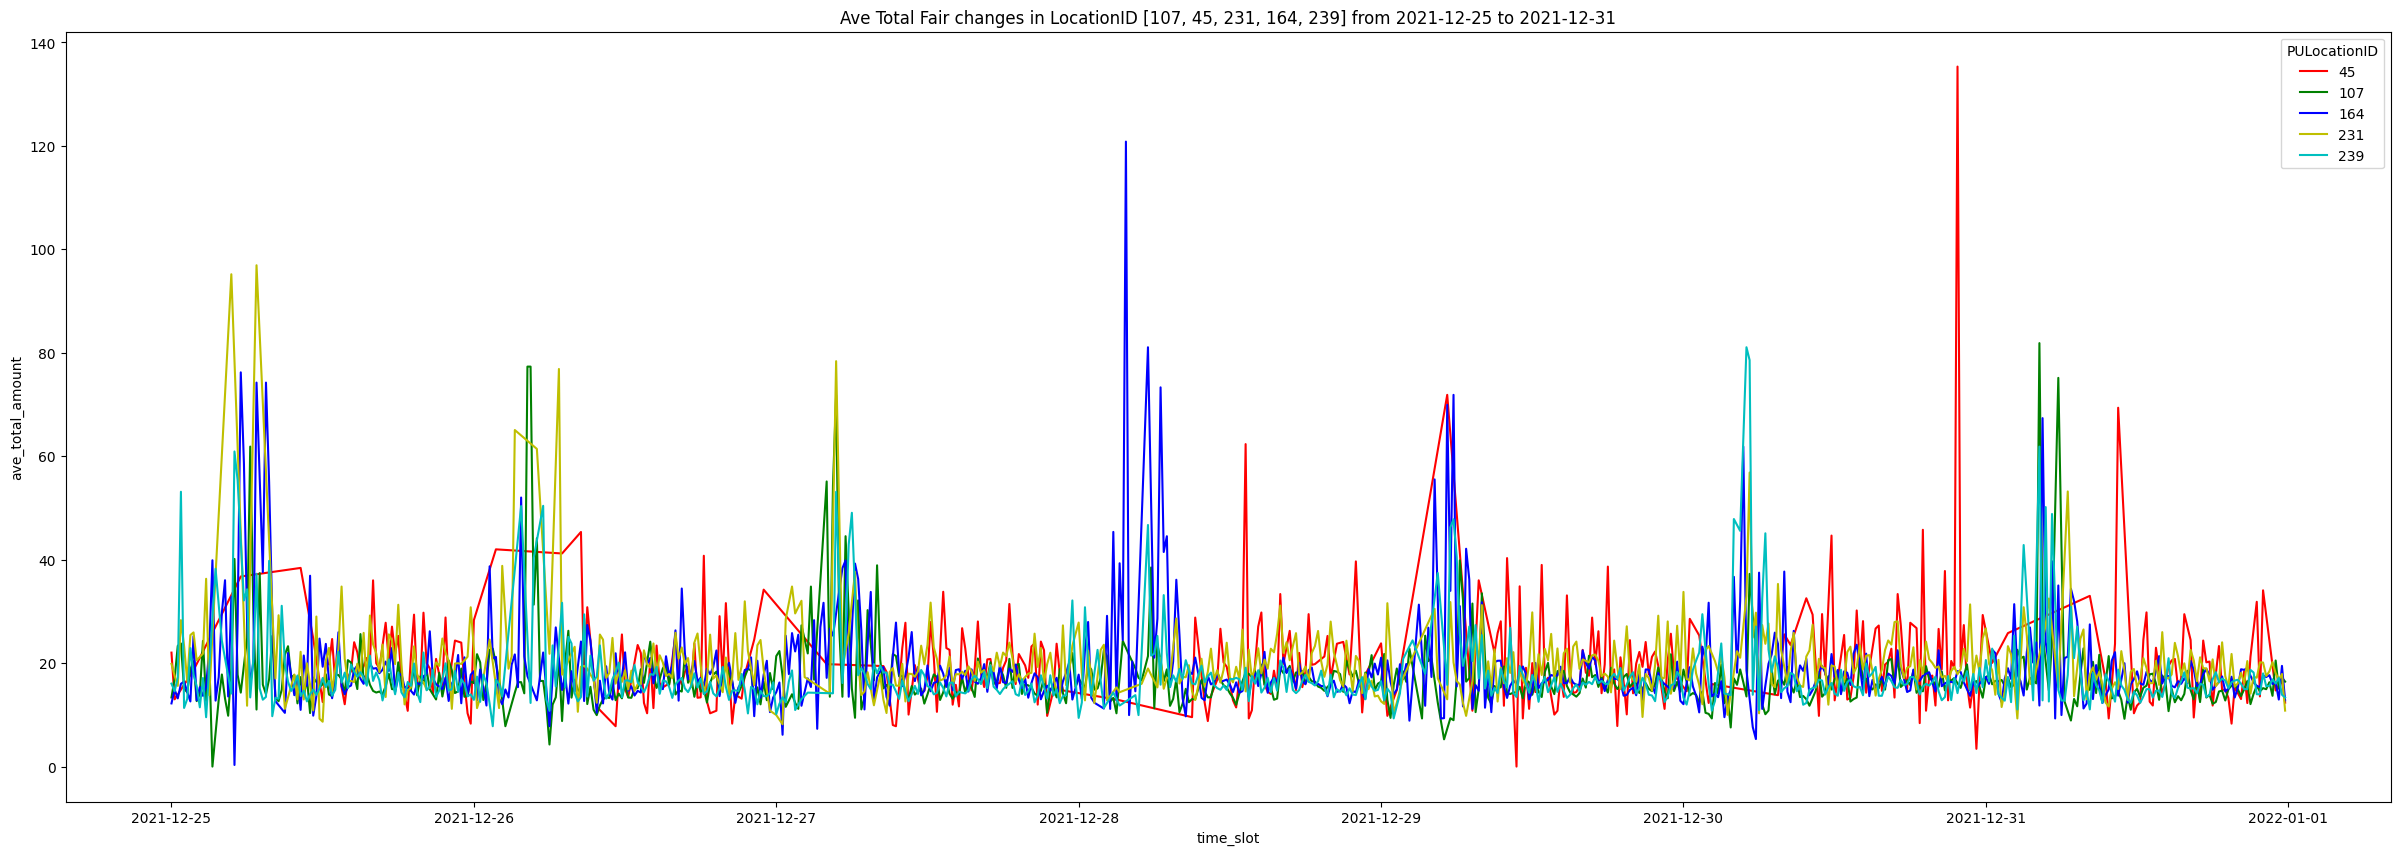

In [26]:
# Plot ave toral amount changes of 5 randomly selected regions across 7 days
days_of_data = 7
pu_count.sort_values(by='time_slot', ascending = False, inplace = True)
date_range = [x for x in pd.to_datetime(pu_count.y_m_d).dt.strftime('%Y-%m-%d').unique()[:days_of_data]]

pu_count_gr_7days = pu_count.loc[(pd.to_datetime(pu_count.y_m_d)).isin(date_range)]
rand_loc = list(pu_count_gr_7days.PULocationID.sample(n=5, random_state=1))
pu_count_gr_7days = pu_count_gr_7days.loc[pu_count_gr_7days.PULocationID.isin(rand_loc)]

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title(f"Ave Total Fair changes in LocationID {rand_loc} from {pu_count_gr_7days.y_m_d.iloc[-1]} to {pu_count_gr_7days.y_m_d.iloc[0]}")
pu_plot_7 = sns.lineplot(ax=ax, data=pu_count_gr_7days,  x="time_slot", y="ave_total_amount", hue="PULocationID", palette=['r', 'g', 'b', 'y', 'c'])